# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import re

from matplotlib import pyplot as plt

## 0.1 Helper Functions

In [2]:
def descriptive_statistics_num(num_attributes):
    # Central Tendecy (Mean and Median)
    c1 = pd.DataFrame(num_attributes.apply(lambda x: np.mean(x)))
    c2 = pd.DataFrame(num_attributes.apply(lambda x: np.median(x)))

    # Dispersion
    d1 = pd.DataFrame(num_attributes.apply(lambda x: (x).min()))
    d2 = pd.DataFrame(num_attributes.apply(lambda x: (x).max()))
    d3 = pd.DataFrame(num_attributes.apply(lambda x: (x).max() - (x).min()))
    d4 = pd.DataFrame(num_attributes.apply(lambda x: np.std(x)))
    d5 = pd.DataFrame(num_attributes.apply(lambda x: (x).skew()))
    d6 = pd.DataFrame(num_attributes.apply(lambda x: (x).kurtosis()))

    a = pd.concat([d1,d2,d3, c1,c2,d4,d5,d6], axis = 1)
    a.columns = ['min', 'max','range','mean','median','std','skew','kurtosis']
    return a


def ols(column):
    
    x1 = x_price[[column]]
    y1 = y_demand[[column]]

    # adicionando constante
    X1 = sm.add_constant(x1)

    # treinando modelo
    model = sm.OLS(y1, X1)
    results = model.fit()
    
    if results.f_pvalue < 0.05:
        rsquared = results.rsquared
        p_value = results.f_pvalue
        intercept, slope = results.params
        mean_price = np.mean(x_price[[column]])
        mean_quantity = np.mean(y_demand[[column]])

        price_elasticity = slope*(mean_price/mean_quantity)

        results_values['name'].append(column)
        results_values['price_elasticity'].append(price_elasticity)
        results_values['price_mean'].append(mean_price)
        results_values['quantity_mean'].append(mean_quantity)
        results_values['intercept'].append(intercept)
        results_values['slope'].append(slope)
        results_values['rsquared'].append(rsquared)
        results_values['p_value'].append(p_value)

def ols_cross(column1, column2):
    
    x1 = x_price[[column1]]
    y1 = y_demand[[column2]]

    # adicionando constante
    X1 = sm.add_constant(x1)

    # treinando modelo
    model = sm.OLS(y1, X1)
    results = model.fit()
    
    if results.f_pvalue < 0.05:
        rsquared = results.rsquared
        p_value = results.f_pvalue
        intercept, slope = results.params
        mean_price = np.mean(x_price[[column1]])
        mean_quantity = np.mean(y_demand[[column2]])

        price_elasticity = slope*(mean_price/mean_quantity)

        results_values1['column_price'].append(column1)
        results_values1['column_demand'].append(column2)
        results_values1['price_elasticity'].append(price_elasticity)
        results_values1['price_mean'].append(mean_price)
        results_values1['quantity_mean'].append(mean_quantity)
        results_values1['intercept'].append(intercept)
        results_values1['slope'].append(slope)
        results_values1['rsquared'].append(rsquared)
        results_values1['p_value'].append(p_value)

def recomendation(produto):
    recomend = df_elasticity1[df_elasticity1['column_price'] == produto].sort_values(by='price_elasticity', ascending = True).head(5)
    lista_recomend = recomend['column_demand'].tolist()

    a = 0
    print(f'Produto: {produto}')
    for i in lista_recomend:
        a += 1
        print(f"{a}. {i}")

## 0.2 Loading Dataset

In [3]:
# load data
path = '/home/tiagobarreto/DS/repos/elasticidade_preco'
df_raw = pd.read_csv(path +'/data/raw/transactions.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 0', axis = 1)

# 1.0 Descrição dos Dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
columns = ['Date_imp',
 'Category_name',
 'name',
 'price',
 'merchant',
 'brand',
 'currency',
 'weight']

# Transformando os nomes das colunas para letras minúsculas
columns_lower = [col.lower() for col in columns]

# Atribuindo os novos nomes de colunas ao DataFrame
df1.columns = columns_lower[:len(df1.columns)]

## 1.2 Data Dimensions, Types e NA

In [6]:
df1.shape

(23151, 8)

## 1.3 Datatypes

In [7]:
df1.dtypes

date_imp          object
category_name     object
name              object
price            float64
merchant          object
brand             object
currency          object
weight            object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().mean()

date_imp         0.000000
category_name    0.000000
name             0.000000
price            0.000000
merchant         0.000000
brand            0.000000
currency         0.000000
weight           0.002937
dtype: float64

## 1.5 Replace NA

## 1.6 Change Datatypes

In [9]:
# date_imp
df1['date_imp'] = pd.to_datetime(df1['date_imp'], format='%Y-%m-%d %H:%M:%S')



# 2.0 Feature Engineering

In [10]:
df2 = df1.copy()

In [11]:
# criando variável mês
df2['month'] = df2['date_imp'].dt.month

# 3.0 EDA

In [12]:
df3 = df2.copy()

## 3.1 Price
- Min e Max extremos.

In [13]:
descriptive_statistics_num(df3.loc[:, ['price']])

,min,max,range,mean,median,std,skew,kurtosis
price,1.0,10879.95,10878.95,513.037803,199.99,859.091448,4.59516,34.411146


## 3.2 Month
- O mês 4 tem poucas transações, vai gerar muitos outliers posteriormente.

<Axes: xlabel='month', ylabel='date_imp'>

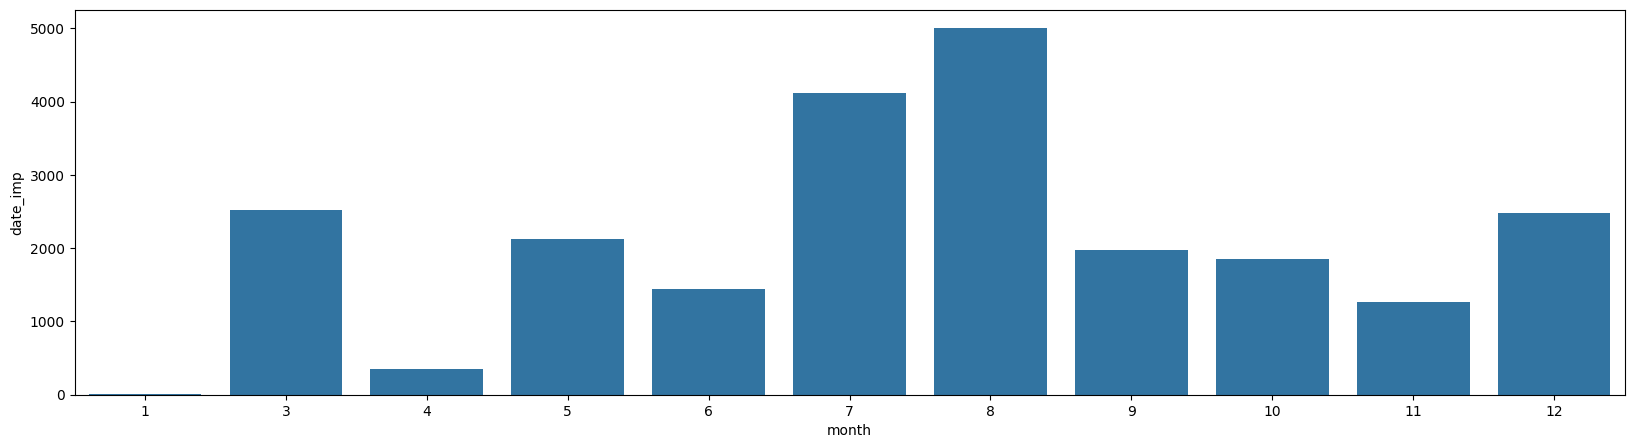

In [14]:
plt.figure(figsize=(20, 5))
df_aux = df3[['month', 'date_imp']].groupby('month').count().reset_index()
sns.barplot(x='month', y='date_imp', data = df_aux)

## 3.3 Merchant
- Bestbuy.com é o merchant com maior volume de transações

<Axes: xlabel='merchant', ylabel='date_imp'>

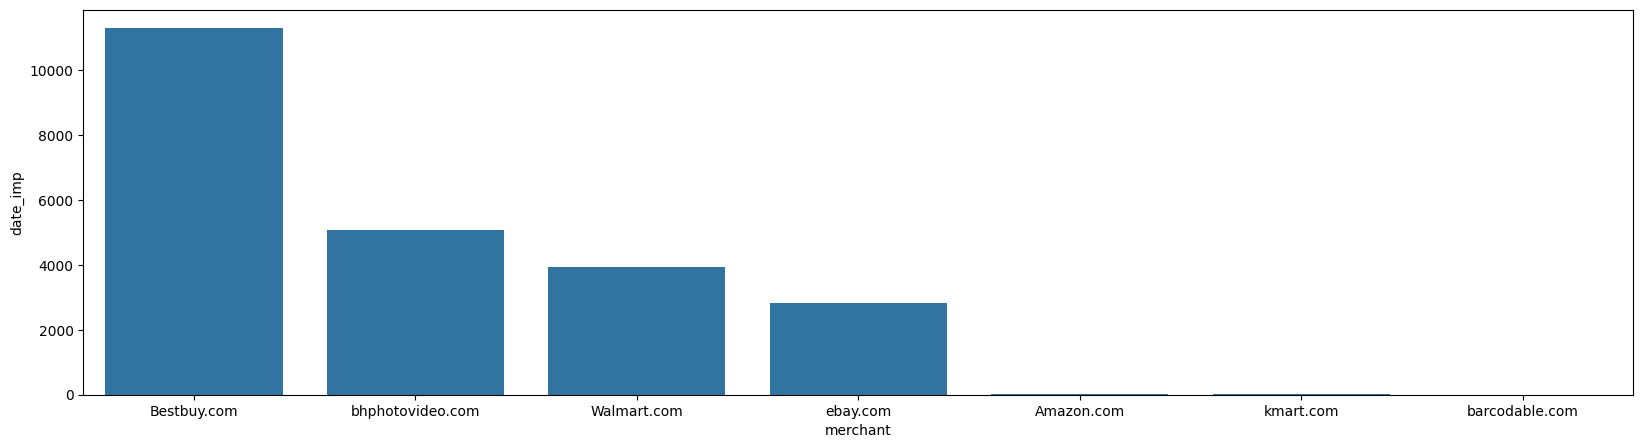

In [15]:
plt.figure(figsize=(20, 5))
df_aux = df3[['merchant', 'date_imp']].groupby('merchant').count().sort_values(by='date_imp', ascending = False).reset_index()
sns.barplot(x='merchant', y='date_imp', data = df_aux)

## 3.4 Marca

([0, 1, 2], [Text(0, 0, 'Sony'), Text(1, 0, 'Apple'), Text(2, 0, 'Yamaha')])

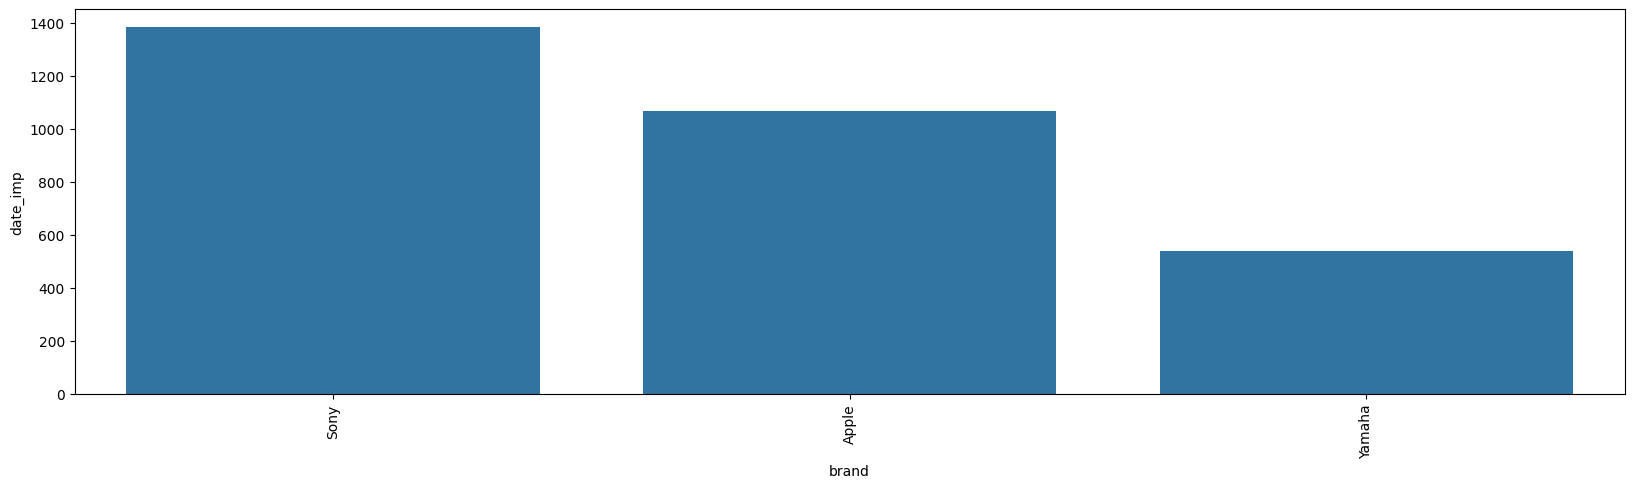

In [16]:
plt.figure(figsize=(20, 5))
df_aux = df3.loc[df3['merchant'] == 'Bestbuy.com' , ['brand', 'date_imp']].groupby('brand').count().sort_values(by='date_imp', ascending = False).head(3).reset_index()

sns.barplot(x='brand', y='date_imp', data = df_aux)
plt.xticks(rotation = 90)

### 3.4.1 Apple
- Vendas a $1.00: Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - Intel Core i5 Dual-core (2 Core) 2 GHz - 8 GB LPDDR3 - 256 GB SSD - Mac OS X 10.12 Sierra - 2560 x 1600
- Vendas a $1.00: Apple 13.3 MacBook Air ( Silver)"

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/elasticidade/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


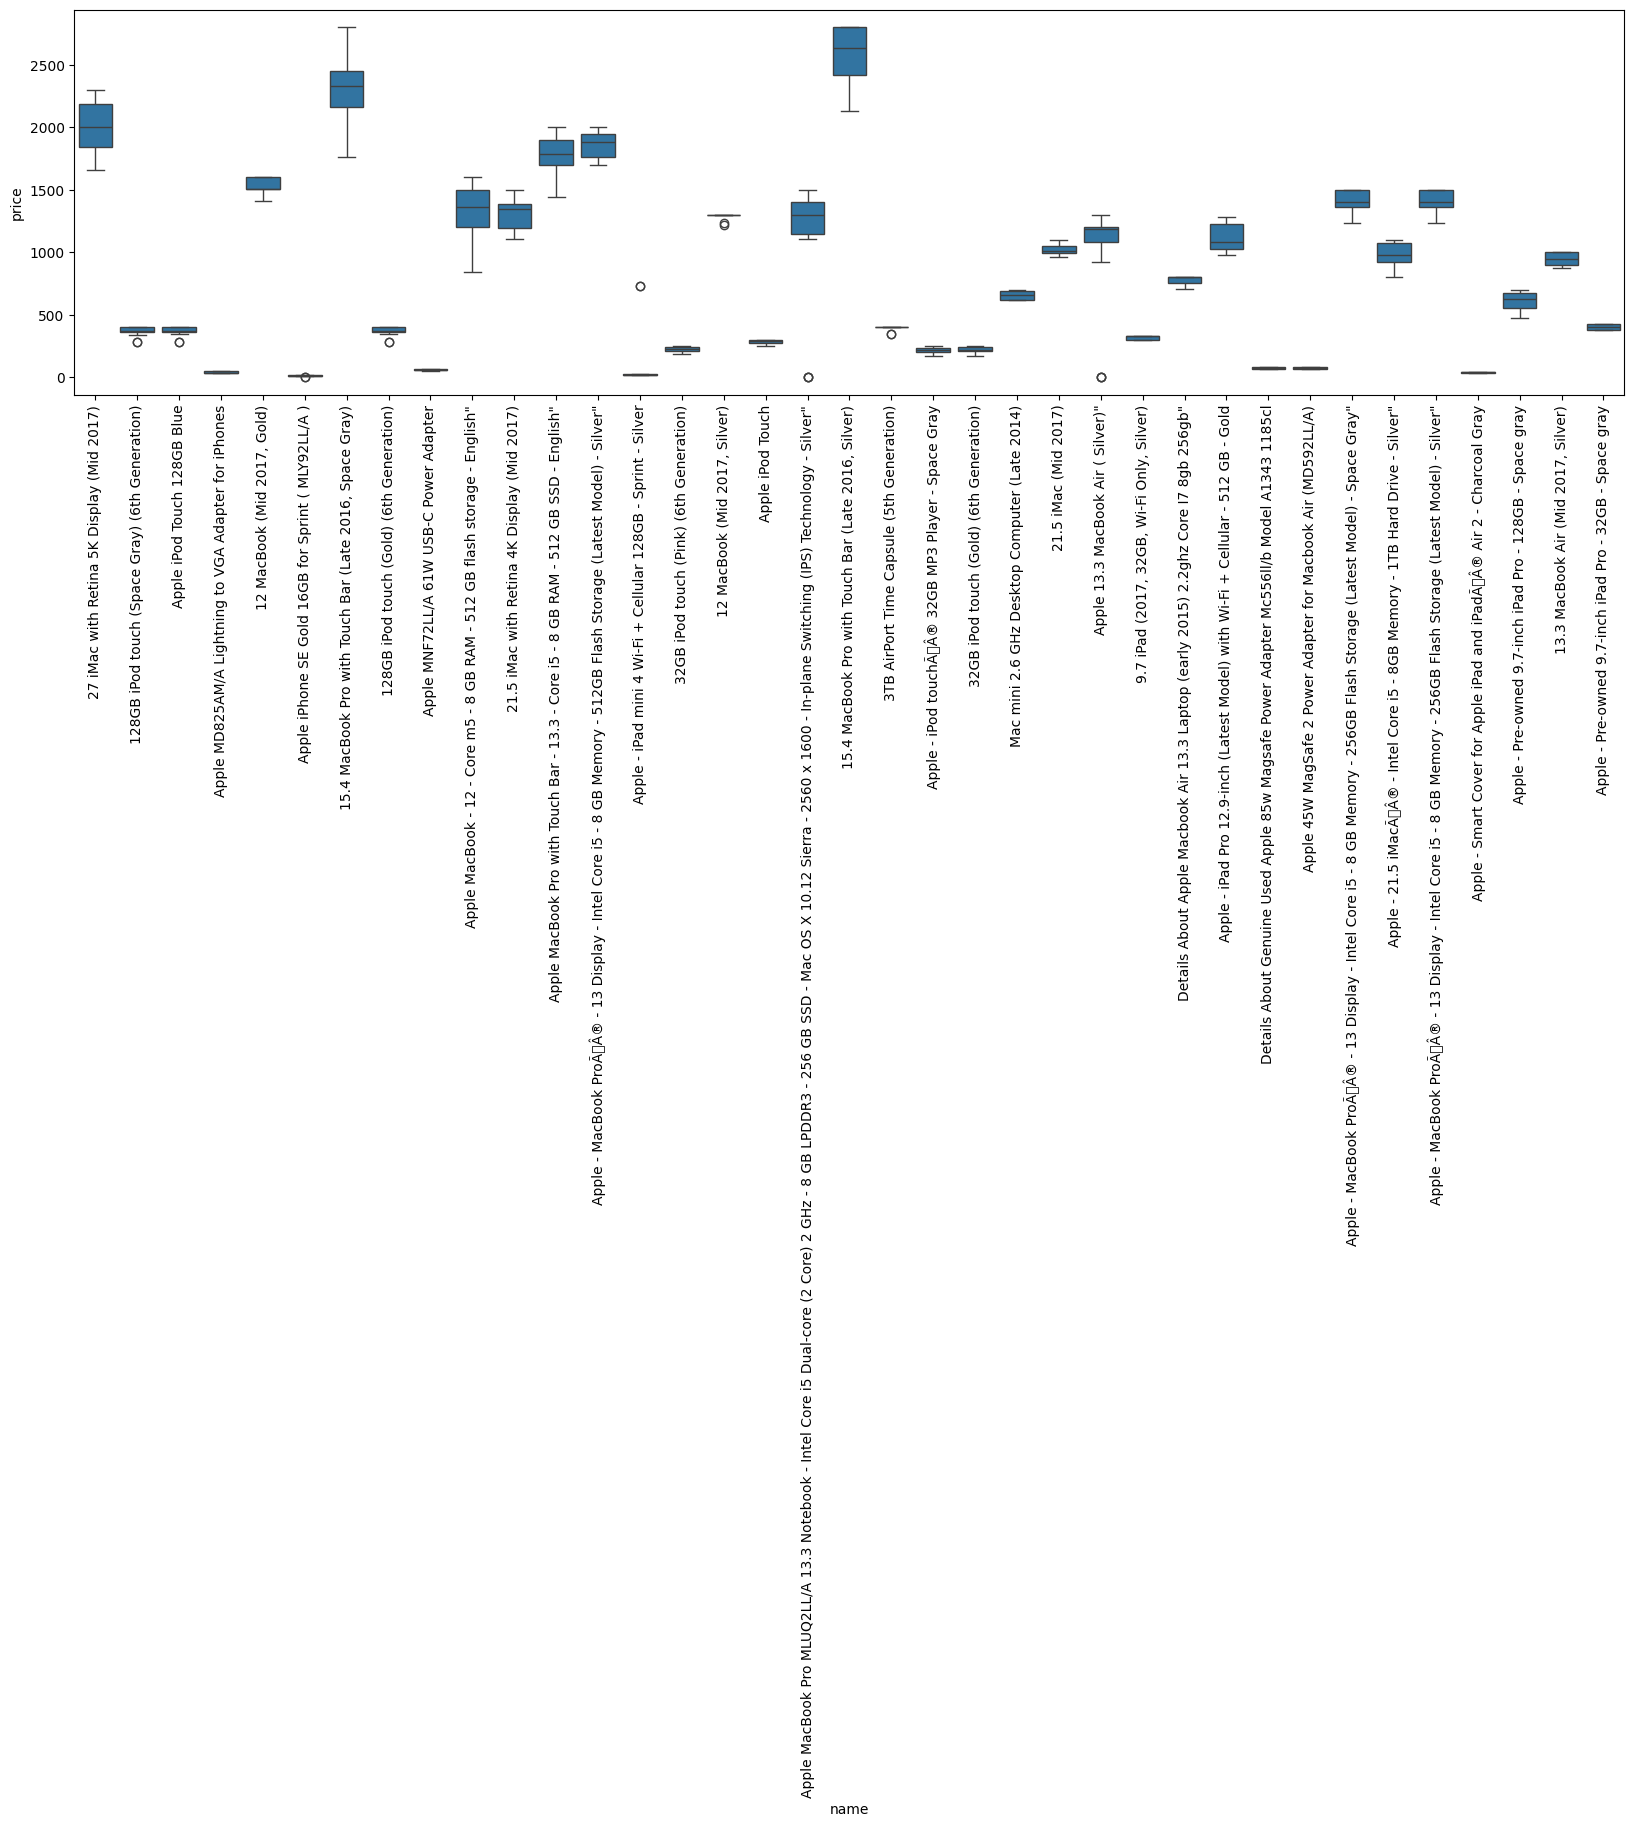

In [17]:
aux = df3.loc[(df3['merchant'] == 'Bestbuy.com') & (df3['brand'] == 'Apple'), ['brand', 'price','name']]

plt.figure(figsize=(20,5))
sns.boxplot(x='name', y='price', data = aux);
plt.xticks(rotation = 90);
plt.show()

In [18]:
## Investigando
# aux[aux['name'] == 'Apple MacBook Pro MLUQ2LL/A 13.3 Notebook - Intel Core i5 Dual-core (2 Core) 2 GHz - 8 GB LPDDR3 - 256 GB SSD - Mac OS X 10.12 Sierra - 2560 x 1600 - In-plane Switching (IPS) Technology - Silver"']
# aux[aux['name'] == 'Apple 13.3 MacBook Air ( Silver)"']




### 3.4.2 Sony
- Alpha a7S II Mirrorless Digital Camera Body with Accessories Kit: vendas a $2.00
- XBR-X850E-Series 75-Class HDR UHD Smart LED TV e Sony - 55 Class - OLED - A1E Series - 2160p - Smart - 4K UHD TV with HDR" com outliers mas parecem normais dentro do contexto.

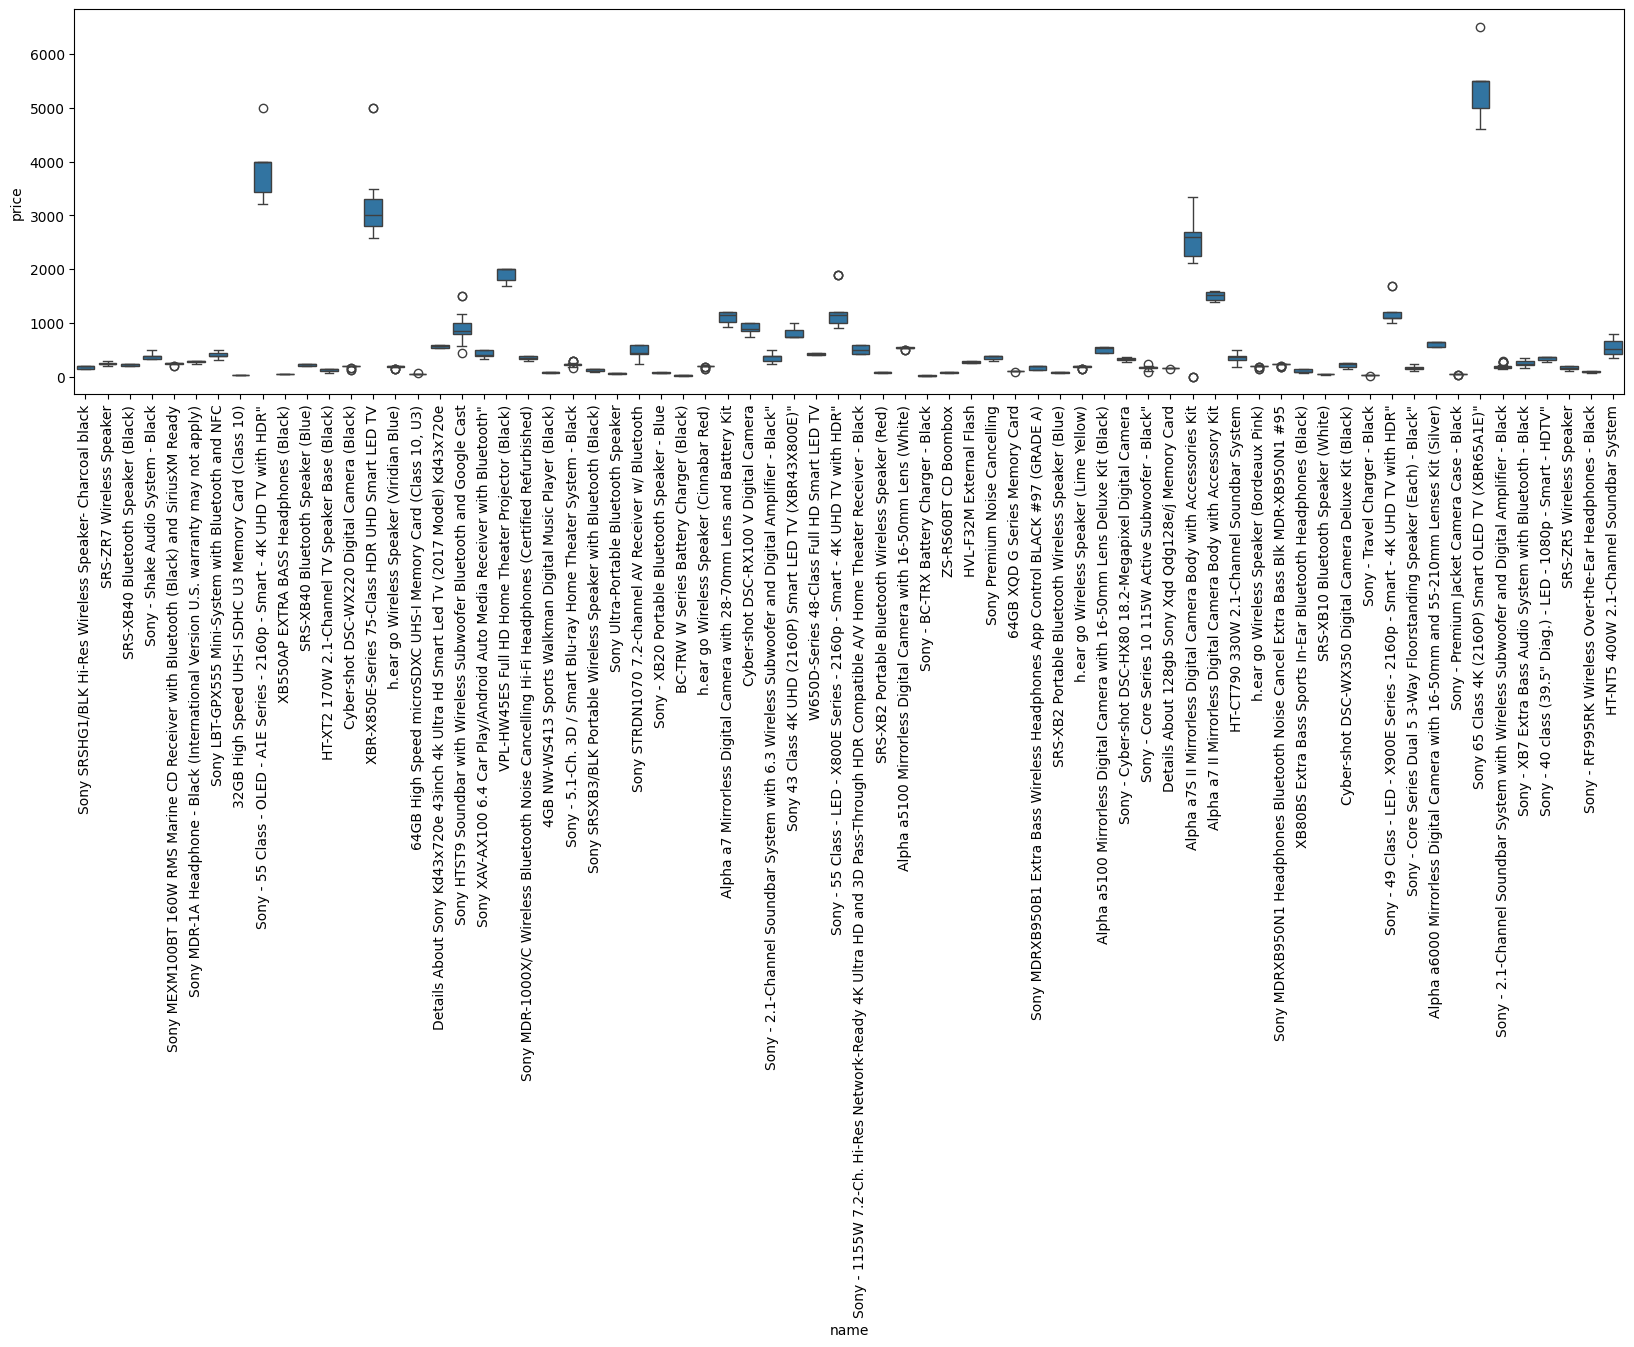

In [19]:
aux = df3.loc[(df3['merchant'] == 'Bestbuy.com') & (df3['brand'] == 'Sony'), ['brand', 'price','name']]

plt.figure(figsize=(20,5))
sns.boxplot(x='name', y='price', data = aux)
plt.xticks(rotation = 90);

In [20]:
# aux[aux['name'] == 'Alpha a7S II Mirrorless Digital Camera Body with Accessories Kit'].sort_values(by='price', ascending = False)

In [21]:
# aux[aux['name'] == 'Sony - 55 Class - OLED - A1E Series - 2160p - Smart - 4K UHD TV with HDR"'].sort_values(by='price', ascending = False)
# aux[aux['name'] == 'XBR-X850E-Series 75-Class HDR UHD Smart LED TV'].sort_values(by='price', ascending = False)

## 3.5 Produto

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/elasticidade/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/elasticidade/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


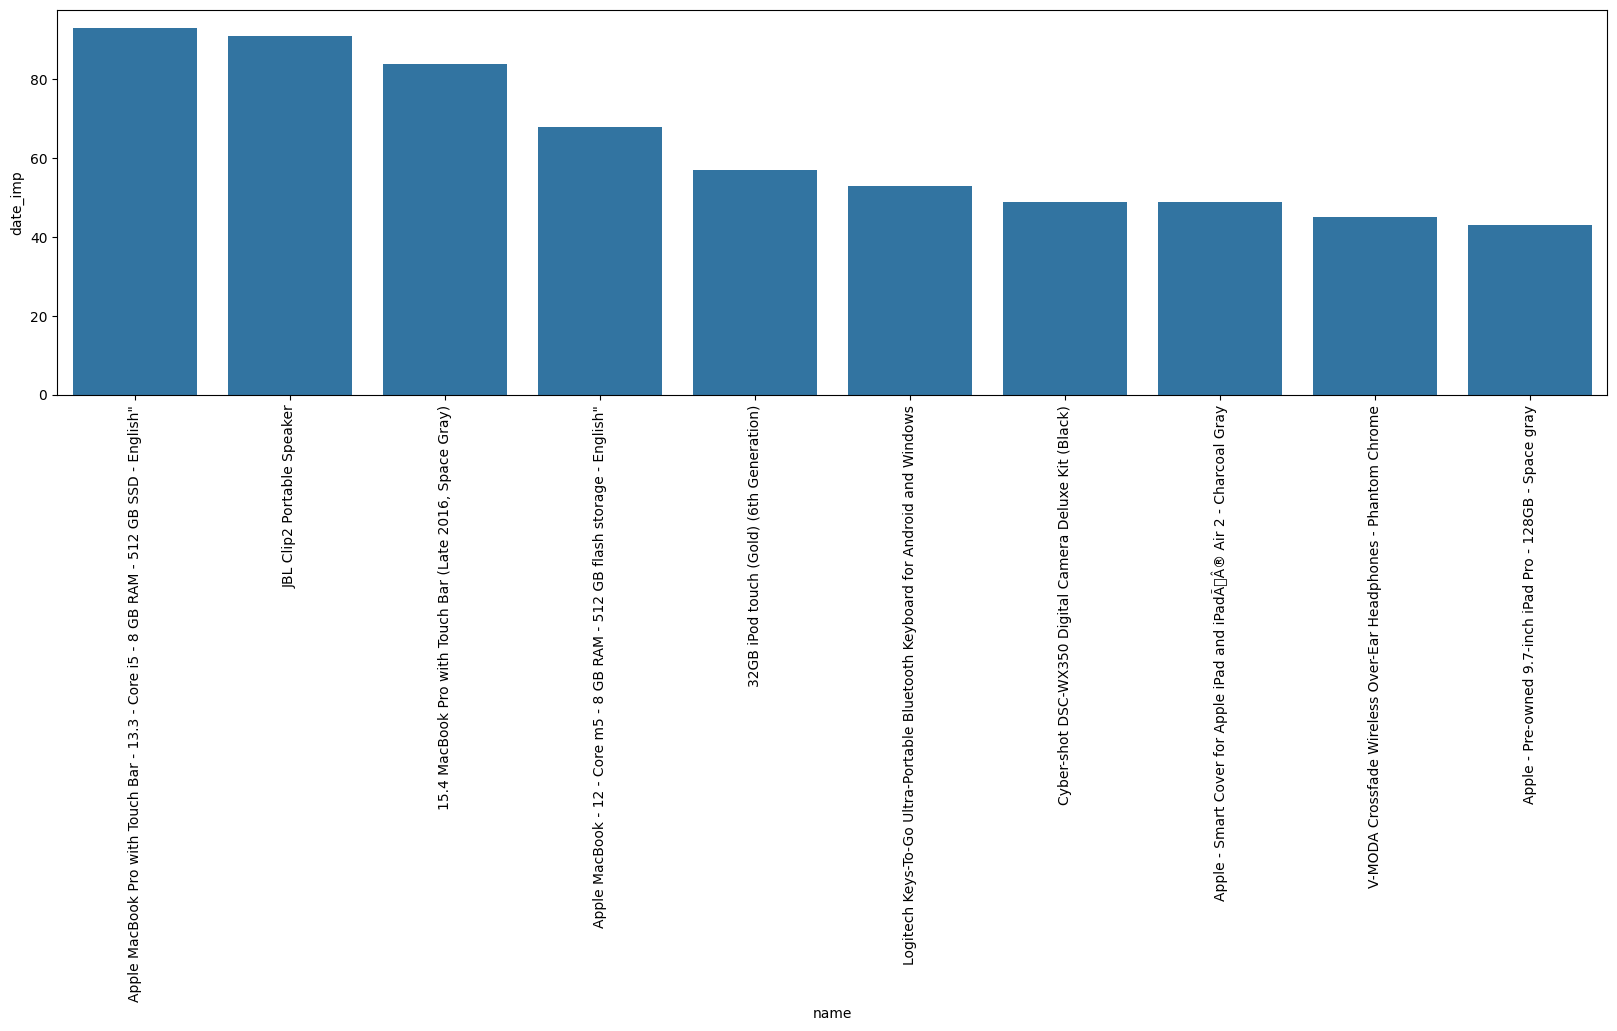

In [22]:
plt.figure(figsize=(20, 5))
df_aux = df3.loc[df3['merchant'] == 'Bestbuy.com' , ['name', 'date_imp']].groupby('name').count().sort_values(by='date_imp', ascending = False).head(10).reset_index()
sns.barplot(x='name', y='date_imp', data = df_aux)
plt.xticks(rotation = 90);

## 3.6 Conclusões
- Filtrar por transações a partir do mês 05-2017.
- Filtrar merchant Bestbuy.com
- Filtrar preço acima de $5.00 para remover os outliers encontrados na Apple e Sony, marcas com maior demanda

# 4.0 Filtragem de Variáveis

## 4.1 Filtragem Linhas

In [23]:
# criando filtro de vendas somente do Bestbuy.com
filtro = df3.loc[df3['merchant'] == 'Bestbuy.com', 'name'].tolist()

# filtrando mês, merchant e preço
df4 = df3.loc[(df3['month'] >= 5) & (df3['name'].isin(filtro)) & (df3['price'] > 5), :]

## 4.2 Filtragem Colunas

In [24]:
df4 = df4[['name', 'date_imp','price','month']]

# 5.0 Preparação dos Dados

In [25]:
df5 = df4.copy()

## 5.1 Soma Agregada

In [26]:
# calculando a soma agregada de quantidade e a média de preço por mês e produto
df5 = df5[['month','name','date_imp','price']].groupby(['month','name']).agg({'date_imp': 'count', 'price': 'mean'}).reset_index()

## 5.2 Tabelas Pivotadas

In [27]:
# criando tabela pivotada do preço e demanda
x_price = df5.pivot(index='month', columns = 'name', values='price')
y_demand = df5.pivot(index='month', columns = 'name', values='date_imp')


## 5.3 Filtrando Tabela Pivotada

In [28]:
# filtrando produtos com mais de 25% de NA -> corresponde a 2 meses sem vender
x_price = x_price.loc[:, x_price.isna().mean() <= 0.25]
y_demand = y_demand.loc[:, y_demand.isna().mean() <= 0.25]

## 5.4 Preenchendo NA Tabela Pivotada

In [29]:
# tenta preencher com o preço anterior e se não achar com o próximo valor
x_price = x_price.fillna(method='ffill')
x_price = x_price.fillna(method='bfill')

# preenche com 0 os meses que não tem venda do produto
y_demand = y_demand.fillna(0)

/tmp/ipykernel_564/1878832577.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_price = x_price.fillna(method='ffill')
/tmp/ipykernel_564/1878832577.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_price = x_price.fillna(method='bfill')


# 6.0 Machine Learning

In [30]:
# criando dicionario para guardar valores da OLS
results_values = {
    "name": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "slope": [],
    "rsquared": [],
    "p_value": []
}

# loop para iterar sobre todos os produtos e passar pela função ols que retorna todo o método OLS já calculado
for i in x_price.columns:
    ols(i)

# criando data_frame com o dicionario results_values
df_elasticity = pd.DataFrame.from_dict(results_values)

# filtrando outliers com mais de 100 de elasticidade
df_elasticity = df_elasticity[df_elasticity['price_elasticity'] < 100]

# 7.0 Elasticidade

## 7.1 Ranqueamento

In [31]:
df_elasticity['ranking'] = df_elasticity['price_elasticity'].rank(ascending=True).astype(int).reset_index(drop = True)

## 7.2 Salvando o DataFrame de Elasticidade Tratado

In [51]:
# df_elasticity.to_csv('data/treated/df_elasticity.csv')

## 7.3 Visualização

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/elasticidade/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/elasticidade/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


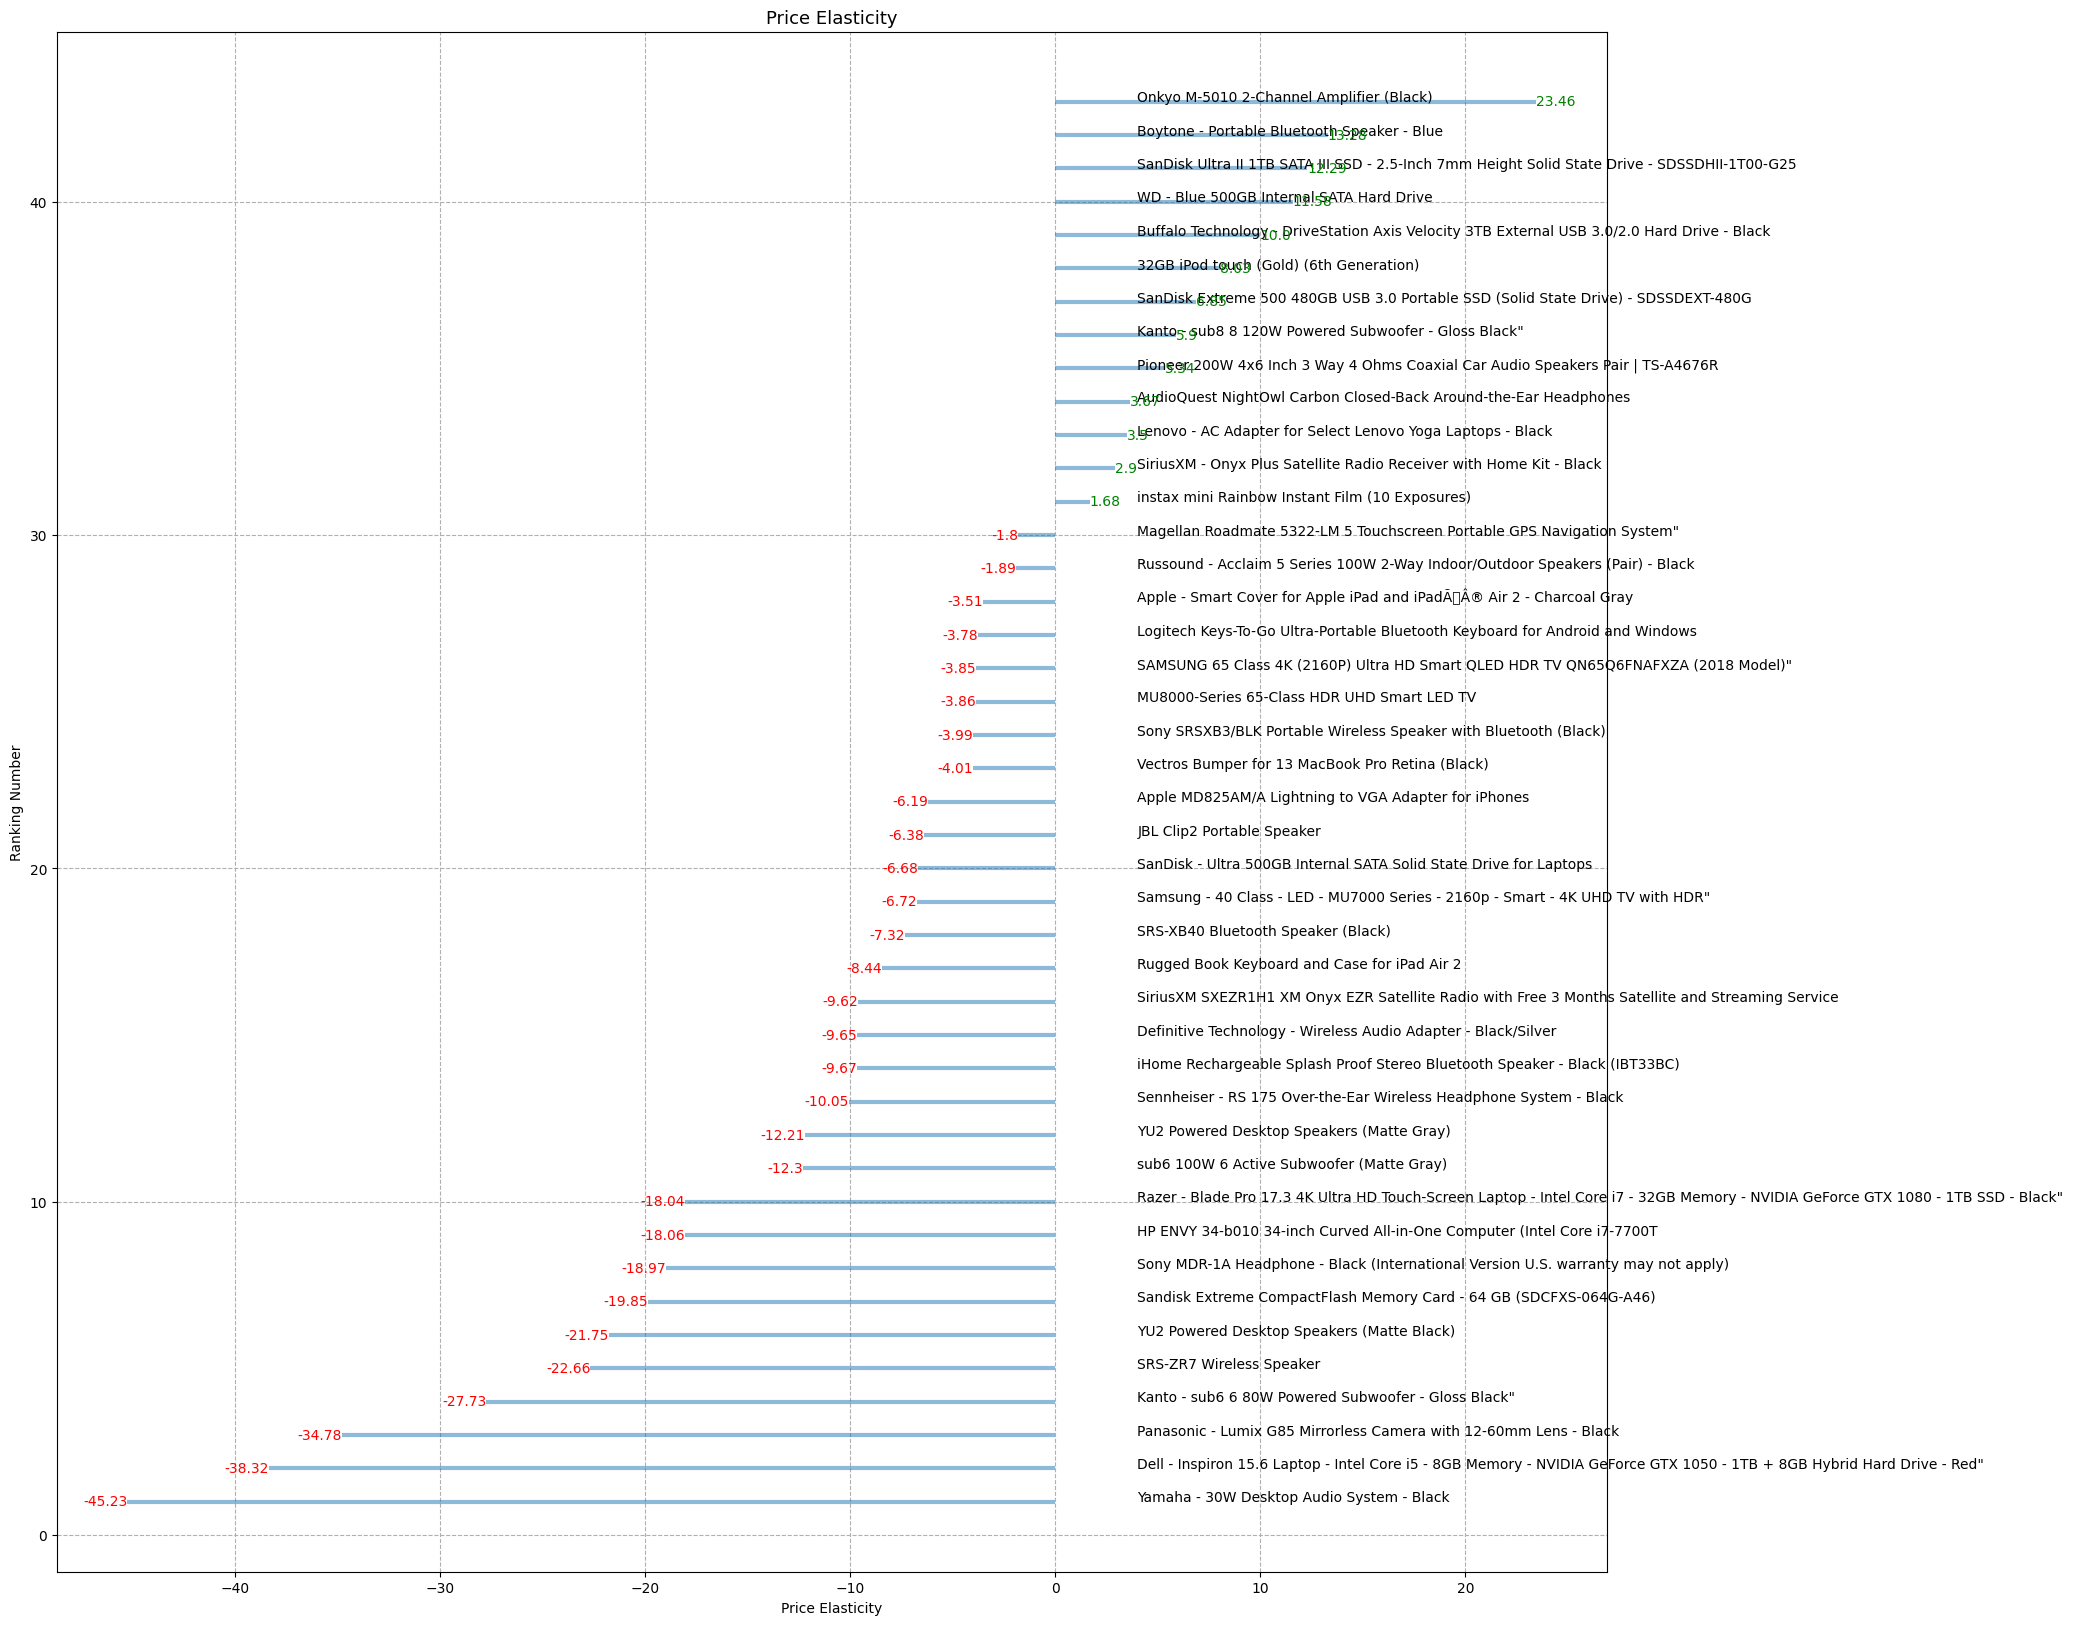

In [32]:
plt.figure(figsize = (20,20))
plt.hlines(y = df_elasticity['ranking'] , xmin = 0, xmax = df_elasticity['price_elasticity'], alpha = 0.5, linewidth = 3)

for name, p in zip(df_elasticity['name'], df_elasticity['ranking']):
    plt.text(4, p, name)

 #Add elasticity labels
for x, y, s in zip(df_elasticity['price_elasticity'], df_elasticity['ranking'], df_elasticity['price_elasticity']):
    plt.text(x, y, round(s, 2), horizontalalignment='right' if x < 0 else 'left', 
                                verticalalignment='center', 
                                fontdict={'color':'red' if x < 0 else 'green', 'size':10})
    
plt.gca().set(ylabel= 'Ranking Number', xlabel= 'Price Elasticity')
plt.title('Price Elasticity' , fontdict={'size':13})
plt.grid(linestyle='--')



## 7.4 Produtos com Elasticidade Positiva e Negativa
- Positiva: Aumento no Preço -> Aumento na Demanda
- Negativa: Aumento no Preço -> Redução da Demanda 

In [33]:
elasticidade_positiva = df_elasticity[df_elasticity['price_elasticity'] > 0]
elasticidade_negativa = df_elasticity[df_elasticity['price_elasticity'] < 0]

# 8.0 Business Performance

## 8.1 Filtrando produtos que tiveram vendas no mês de Dezembro 2017

In [53]:
# criando filtro dos produtos com significância estatística
produtos = df_elasticity['name'].tolist()

# filtrando o dataframe pelos produtos com significância no mês de dezembro de 2017
df8 = df5.loc[(df5['name'].isin(produtos)) & (df5['month'].isin([12])), :].reset_index(drop = True)


## 8.2 Preparação

In [54]:
# calculando vendas e preço por produto
df8 = df8[['name','date_imp','price']].groupby('name').agg({'date_imp': 'sum', 'price': 'mean'}).reset_index()

### 8.2.1 Juntando as elasticidades positivas e negativas 

In [55]:
# left join entre df8 com elasticidade_positiva
df8 = pd.merge(df8, elasticidade_positiva[['name','price_elasticity']], on='name', how='left')

# left join entre df8 com elasticidade_negativa
df8 = pd.merge(df8, elasticidade_negativa[['name','price_elasticity']], on='name', how='left')

# juntando as duas elasticidades em uma coluna
df8['price_elasticity'] = df8['price_elasticity_x'].combine_first(df8['price_elasticity_y'])

# dropando as colunas criadas anteriormente
df8 = df8.drop(columns = ['price_elasticity_x', 'price_elasticity_y'])

### 8.2.2 Salvando Datafram de Business Performance

In [57]:
# df8.to_csv('data/treated/business.csv')

## 8.3 Simulação de Desconto de 25% produtos com Elasticidade Negativa e Aumento de 10% nos de Elasticidade Positiva

### 8.3.1 Feature Engineering

In [59]:
# criando variável com gasto total
df8.loc[:, 'total_spent'] = df8['date_imp'] * df8['price']

desconto = 0.25
aumento = 0.10


# criando o novo preço
# - se a elasticidade for negativa vai ter um desconto de 25% nos produtos
# - se a elasticidade for positiva vai ter um aumento de 10% nos produtos
df8['new_price'] = df8.apply(lambda x: x['price'] * (1- desconto)
                             if (x['price_elasticity'] < 0) 
                             else x['price'] * (1 + aumento), 
                             axis = 1)


# criando a nova quantidade
# - se a elasticidade for negativa vai ter um aumento na demanda de 1 + 0.25 x elasticidade 
# - se a elasticidade for positiva vai ter um aumento na demanda de 1 + 0.10 x elasticidade 
df8['new_quantity'] = df8.apply(lambda x: x['date_imp'] * (1 + desconto * abs(x['price_elasticity']))
                                if (x['price_elasticity'] < 0) 
                                else x['date_imp'] * (1 + aumento * abs(x['price_elasticity'])), 
                                axis=1)

# arredonando a quantidade                     
df8['new_quantity'] = np.round(df8['new_quantity'], 0)

# calculando novo gasto total
df8['new_spent'] = abs(df8['new_price'] * df8['new_quantity'])

# calculando crescimento de lucro por produto
df8['growth_spent'] = (df8['new_spent'] - df8['total_spent']) / df8['total_spent']


### 8.3.2 Filtrando

In [61]:
# filtrando produtos que tiveram um aumento percemtual no faturamento menor que 30%
growth_percentage = 0.3
df8 = df8[(df8['growth_spent'] > growth_percentage)]

### 8.3.3 Resultado


In [62]:
faturamento_dez = np.round(df8['total_spent'].sum(), 2)
faturamento_exp = np.round(df8['new_spent'].sum(), 2)
growth = np.round(100* (faturamento_exp - faturamento_dez) / faturamento_dez, 2)

print(f'Faturamento Dezembro 2017 sem otimização de preços: ${faturamento_dez}')
print(f'Expectativa faturamento Janeiro 2018 com otimização de preços: ${faturamento_exp}')
print(f'Crescimento no Faturamento: {growth}%')

Faturamento Dezembro 2017 sem otimização de preços: $56437.73
Expectativa faturamento Janeiro 2018 com otimização de preços: $174840.04
Crescimento no Faturamento: 209.79%


# 9.0 Cross-Price Elasticity

## 9.1 Machine Learning

### 9.1.1 Cross OLS

In [40]:
# criando dicionario para cross_price ols 
results_values1 = {
    "column_price": [],
    "column_demand": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "slope": [],
    "rsquared": [],
    "p_value": []
}

# criando lista com nome dos produtos que vão ter desconto
lista = df8['name'].tolist()


# loop para calcular elasticidade entre os diferentes produtos
for j in np.arange(0, (len(lista))):
    for k in np.arange(0, (len(lista))):
        ols_cross(lista[j], lista[k])

# criando data_frame com o dicionario results_values
df_elasticity1 = pd.DataFrame.from_dict(results_values1)

### 9.1.2 Filtrando Dataframe Resultado

In [41]:
# filtrando comparação de elasticidade entre os mesmos produtos
df_elasticity1 = df_elasticity1[df_elasticity1['column_price'] != df_elasticity1['column_demand']]

### 9.1.3 Ranking de Elasticidade

In [42]:
# Calcular o ranking com base no valor absoluto da elasticidade-preço em ordem decrescente
df_elasticity1['ranking'] = df_elasticity1['price_elasticity'].abs().rank(ascending=False).astype(int)

### 9.1.4 Exportando DataFrame de Elasticidade Cruzada

In [66]:
df_cross = df_elasticity1[['column_price', 'column_demand', 'price_elasticity']].sort_values(by=['column_price', 'price_elasticity'], ascending = [False, True])

In [67]:
# df_cross.to_csv('data/treated/cross_elasticity.csv')

## 9.2 Lista Recomendações Complementares

### 9.2.1 YU2 Powered Desktop Speakers (Matte Black)

In [44]:
produto1 = 'YU2 Powered Desktop Speakers (Matte Black)'
recomendation(produto1)

Produto: YU2 Powered Desktop Speakers (Matte Black)
1. Kanto - sub6 6 80W Powered Subwoofer - Gloss Black"
2. SRS-ZR7 Wireless Speaker
3. sub6 100W 6 Active Subwoofer (Matte Gray)
4. SRS-XB40 Bluetooth Speaker (Black)
5. Samsung - 40 Class - LED - MU7000 Series - 2160p - Smart - 4K UHD TV with HDR"


### 9.2.2 Sony MDR-1A Headphone - Black (International Version U.S. warranty may not apply)

In [45]:
produto2 = 'Sony MDR-1A Headphone - Black (International Version U.S. warranty may not apply)'

recomendation(produto2)

Produto: Sony MDR-1A Headphone - Black (International Version U.S. warranty may not apply)
1. SanDisk - Ultra 500GB Internal SATA Solid State Drive for Laptops
2. Sandisk Extreme CompactFlash Memory Card - 64 GB (SDCFXS-064G-A46)
3. Samsung - 40 Class - LED - MU7000 Series - 2160p - Smart - 4K UHD TV with HDR"
4. Panasonic - Lumix G85 Mirrorless Camera with 12-60mm Lens - Black
5. SanDisk Extreme 500 480GB USB 3.0 Portable SSD (Solid State Drive) - SDSSDEXT-480G


### 9.2.3 Kanto - sub6 6 80W Powered Subwoofer - Gloss Black"

In [46]:
produto3 = 'Kanto - sub6 6 80W Powered Subwoofer - Gloss Black"'
recomendation(produto3)

Produto: Kanto - sub6 6 80W Powered Subwoofer - Gloss Black"
1. SRS-ZR7 Wireless Speaker
2. sub6 100W 6 Active Subwoofer (Matte Gray)
3. YU2 Powered Desktop Speakers (Matte Black)
4. SRS-XB40 Bluetooth Speaker (Black)
5. Samsung - 40 Class - LED - MU7000 Series - 2160p - Smart - 4K UHD TV with HDR"


## 9.3 Lista Subtistutos

### 9.3.1 SanDisk Extreme 500 480GB USB 3.0 Portable SSD (Solid State Drive) - SDSSDEXT-480G

In [47]:
produto4 = 'SanDisk Extreme 500 480GB USB 3.0 Portable SSD (Solid State Drive) - SDSSDEXT-480G'
recomendation(produto4)

Produto: SanDisk Extreme 500 480GB USB 3.0 Portable SSD (Solid State Drive) - SDSSDEXT-480G
1. Sandisk Extreme CompactFlash Memory Card - 64 GB (SDCFXS-064G-A46)
2. Sony MDR-1A Headphone - Black (International Version U.S. warranty may not apply)
3. SanDisk - Ultra 500GB Internal SATA Solid State Drive for Laptops
4. Samsung - 40 Class - LED - MU7000 Series - 2160p - Smart - 4K UHD TV with HDR"


### 9.3.2 WD - Blue 500GB Internal SATA Hard Drive

In [48]:
produto5 = 'WD - Blue 500GB Internal SATA Hard Drive'
recomendation(produto5)

Produto: WD - Blue 500GB Internal SATA Hard Drive
1. SanDisk Ultra II 1TB SATA III SSD - 2.5-Inch 7mm Height Solid State Drive - SDSSDHII-1T00-G25
